# Continue a finished workgraph

## Introduction

One of the key features of `WorkGraph` is its ability to continue previous workflows. When a workgraph finishes its execution, it saves its state in the AiiDA process node. This allows you to rebuild the workgraph from the process and add new tasks to continue the workflow.

In the following sections, we will demonstrate how you can load a finished workgraph, amend it with new tasks, and continue the workflow.

In [1]:
%load_ext aiida
from aiida import load_profile

_ = load_profile()

## Submit a workgraph

We first create and submit a simply workgraph, so that we can reload and continue it later.

In [2]:
from aiida_workgraph import WorkGraph

with WorkGraph("AddMultiplyToBeContinued") as wg1:
    wg1.inputs = dict.fromkeys(["x", "y"])
    the_sum = wg1.inputs.x + wg1.inputs.y
    the_product = the_sum * 3
    wg1.outputs.result = {
        "sum": the_sum,
        "product": the_product,
    }

wg1.run(
    inputs={
        "graph_inputs": {
            "x": 1,
            "y": 2,
        }
    },
)

07/14/2025 04:15:02 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_add
07/14/2025 04:15:02 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|update_task_state]: Task: op_add, type: PyFunction, finished.
07/14/2025 04:15:02 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_mul
07/14/2025 04:15:03 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|update_task_state]: Task: op_mul, type: PyFunction, finished.
07/14/2025 04:15:03 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
07/14/2025 04:15:03 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11702|WorkGraphEngine|finalize]: F

In [3]:
print("Results:")
print(f"  Sum: {wg1.outputs.result.sum.value}")
print(f"  Product: {wg1.outputs.result.product.value}")

Results:
  Sum: uuid: 39c81440-3c52-423b-bffb-8aea958539cd (pk: 11706) value: 3
  Product: uuid: d5658a6c-074f-4536-aaa9-fce32e5fa431 (pk: 11710) value: 9


## Modify the workgraph and resubmit

It is possible to reload the workgraph, modify an input, and resubmit. We use the `load` method to load the previous workgraph by its `pk`, mark it for restart, and modify the input of the multiplication task. This allows us to change the behavior of the workgraph without having to redefine it from scratch.


In [ ]:
with WorkGraph.load(wg1.pk) as wg2:
    wg2.name = "AddMultiplyModified"
    wg2.restart()
    wg2.tasks.op_mul.inputs.y = 4

wg2.to_html()

In [5]:
wg2.run()

Reset tasks: ['op_mul']


07/14/2025 04:15:04 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11712|WorkGraphEngine|update_task_state]: Task: op_add, type: PyFunction, finished.
07/14/2025 04:15:04 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11712|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_mul
07/14/2025 04:15:04 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11712|WorkGraphEngine|update_task_state]: Task: op_mul, type: PyFunction, finished.
07/14/2025 04:15:04 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11712|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
07/14/2025 04:15:04 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11712|WorkGraphEngine|finalize]: Finalize workgraph.


In [6]:
print("Results:")
print(f"  Sum: {wg2.outputs.result.sum.value}")
print(f"  Product: {wg2.outputs.result.product.value}")

Results:
  Sum: uuid: 39c81440-3c52-423b-bffb-8aea958539cd (pk: 11706) value: 3
  Product: uuid: 7aac430b-bf0d-46fe-8cd9-a9621f73bd5a (pk: 11716) value: 12


Note that the sum has not changed (the `value`, but more importantly, the `pk`, as it is the same node). The product, however, is the result of the calculation repeating with the new input, hence a brand new node.

## Continue a workgraph

Let's now pick up the previous workgraph and extend it by a second addition, leveraging the results of the previous work.


In [ ]:
with WorkGraph.load(wg2.pk) as wg3:
    wg3.name = "AddMultiplyContinued"
    wg3.inputs = dict.fromkeys(['z'])
    wg3.restart()
    wg3.outputs.result.new_sum = wg3.tasks.op_mul.outputs.result + wg3.inputs.z

wg3.to_html()

In [8]:
print(f"State of WorkGraph : {wg3.state}")
print(f"State of add       : {wg3.tasks.op_add.state}")
print(f"State of multiply  : {wg3.tasks.op_mul.state}")
print(f"State of new add   : {wg3.tasks.op_add1.state}")

State of WorkGraph : PLANNED
State of add       : FINISHED
State of multiply  : FINISHED
State of new add   : PLANNED


Note the `PLANNED` new addition task. Let's run it.

In [9]:
wg3.run(
    inputs={
        "graph_inputs": {
            "z": 5,
        }
    },
)

Reset tasks: []


07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEngine|update_task_state]: Task: op_add, type: PyFunction, finished.
07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEngine|update_task_state]: Task: op_mul, type: PyFunction, finished.
07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_add1
07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEngine|update_task_state]: Task: op_add1, type: PyFunction, finished.
07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
07/14/2025 04:15:06 PM <26873> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11718|WorkGraphEng

In [10]:
print("Results:")
print(f"  Sum: {wg3.outputs.result.sum.value}")
print(f"  Product: {wg3.outputs.result.product.value}")
print(f"  New sum: {wg3.outputs.result.new_sum.value}")

Results:
  Sum: uuid: 39c81440-3c52-423b-bffb-8aea958539cd (pk: 11706) value: 3
  Product: uuid: 7aac430b-bf0d-46fe-8cd9-a9621f73bd5a (pk: 11716) value: 12
  New sum: uuid: 3d1c5488-e4e2-45ee-905e-7011b6de74f8 (pk: 11722) value: 17


Again, note that the previous data nodes are the same. Only the new addition task ran and created a new data node.

## The extended provenance

The full provenance remains intact, including the original workflow.

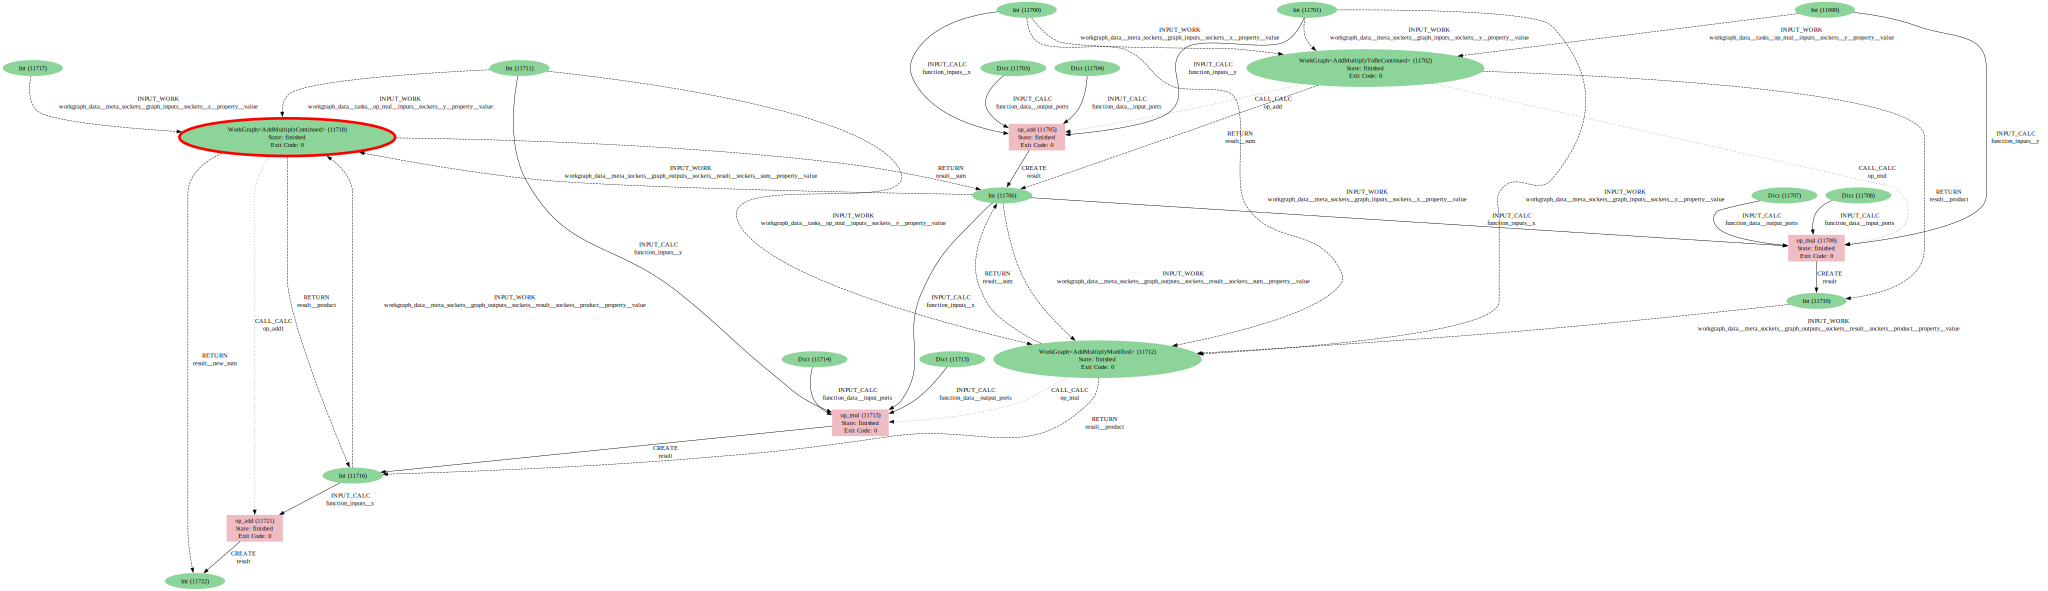

In [11]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg3.pk)

## Summary

In this section, you learned how to load an existing workflow and rerun it with modified input, or continue it with new tasks. These features allow you to extend workflows without losing the original provenance, enabling a flexible and iterative approach to workflow management in AiiDA.